In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
# from src.ParticleFilter import PFHeston
# from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 2.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

1.31


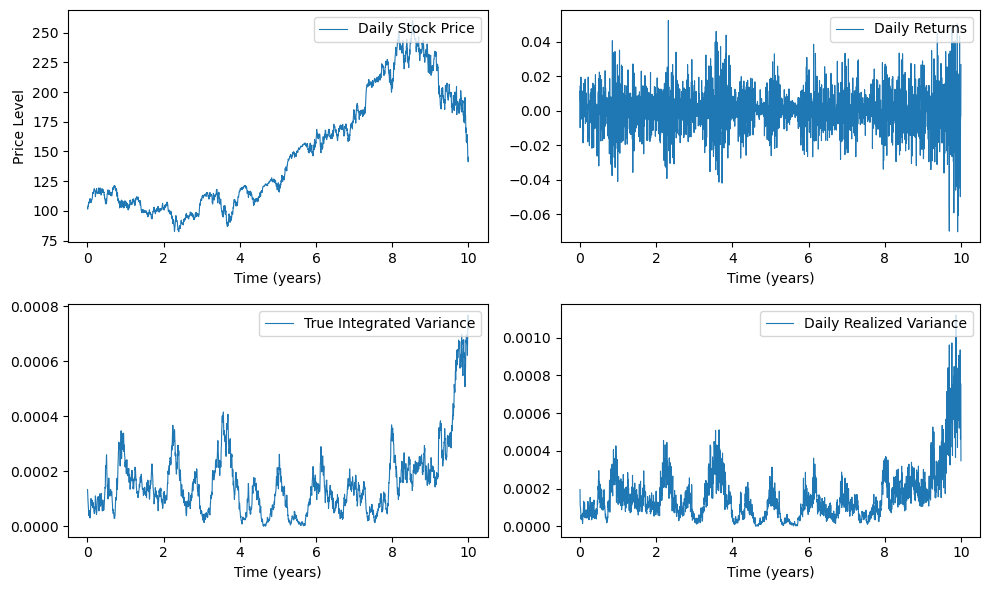

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### RV

In [6]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.90870D+03    |proj g|=  1.63172D+06

At iterate    1    f= -1.01871D+04    |proj g|=  2.93099D+02

At iterate    2    f= -1.11537D+04    |proj g|=  3.56474D-03

At iterate    3    f= -1.11822D+04    |proj g|=  3.56510D-03

At iterate    4    f= -1.12485D+04    |proj g|=  2.66890D-03

At iterate    5    f= -1.12515D+04    |proj g|=  1.99740D+00

At iterate    6    f= -1.12518D+04    |proj g|=  3.97348D+03

At iterate    7    f= -1.12519D+04    |proj g|=  1.77566D+02

At iterate    8    f= -1.12519D+04    |proj g|=  2.63712D-03

At iterate    9    f= -1.12519D+04    |proj g|=  2.63848D-03

At iterate   10    f= -1.12520D+04    |proj g|=  5.86624D-01

At iterate   11    f= -1.12520D+04    |proj g|=  4.44454D+01

At iterate   12    f= -1.12520D+04    |proj g|=  5.15231D+01
  ys=-1.544E-05  -gs= 1.046

### HAR-RV

In [7]:
def har_rv_forecast(train_RV, test_RV):
    train_RV = pd.Series(train_RV)
    test_RV = pd.Series(test_RV)
    
    lag1_tr = train_RV.shift(1)
    lag5_tr = train_RV.rolling(5).mean().shift(1)
    lag21_tr = train_RV.rolling(21).mean().shift(1)
    
    df_tr = pd.DataFrame({
        'y': train_RV,
        'x1': lag1_tr,
        'x5': lag5_tr,
        'x21': lag21_tr
    }).dropna()
    
    X_tr = sm.add_constant(df_tr[['x1', 'x5', 'x21']])
    model = sm.OLS(df_tr['y'], X_tr)
    results = model.fit()
    
    beta_const = results.params['const']
    beta_x1 = results.params['x1']
    beta_x5 = results.params['x5']
    beta_x21 = results.params['x21']
    
    full_RV = pd.concat([train_RV, test_RV])
    
    # Compute lags on the full series
    lag1_full = full_RV.shift(1)
    lag5_full = full_RV.rolling(5).mean().shift(1)
    lag21_full = full_RV.rolling(21).mean().shift(1)
    
    # Extract ONLY the test period features
    test_start_idx = len(train_RV)
    test_end_idx = len(full_RV)
    
    # Test set features
    x1_test = lag1_full.iloc[test_start_idx:test_end_idx]
    x5_test = lag5_full.iloc[test_start_idx:test_end_idx]
    x21_test = lag21_full.iloc[test_start_idx:test_end_idx]
    
    forecasts = beta_const + beta_x1 * x1_test + beta_x5 * x5_test + beta_x21 * x21_test
    
    # forecasts = forecasts.dropna()
    
    if len(forecasts) == 0:
        raise ValueError("All forecasts are NaN. Ensure training data has >21 periods and no missing values.")
    
    # Align with test_RV index
    forecast_index = test_RV.index[:len(forecasts)]
    forecasts = pd.Series(forecasts.values, index=forecast_index, name='HAR_RV_pred')
    
    # Get fitted values (in-sample fit) from training phase
    fitted_values = results.fittedvalues
    n_missing = len(train_RV) - len(fitted_values)
    if n_missing > 0:
        padding = pd.Series([0.0] * n_missing, index=train_RV.index[:n_missing])
        fitted_values = pd.concat([padding, fitted_values])
        fitted_values.name = 'HAR_RV_fitted'
    
    # Return parameters as a dictionary for clarity
    params_dict = {
        'const': beta_const,
        'x1': beta_x1,
        'x5': beta_x5, 
        'x21': beta_x21
    }
    
    return np.array(forecasts), np.array(fitted_values), params_dict, results

In [8]:
pred_HAR, fit_HAR, params_HAR, results_HAR = har_rv_forecast(train_RV, test_RV)

## ARIMA

In [9]:
def arima_rv_forecast(train_RV, test_RV, max_p=5, max_d=2, max_q=5, ic='aic'):

    train_RV = pd.Series(train_RV)
    test_RV = pd.Series(test_RV)
    
    # 1) MODEL SELECTION: Find optimal (p,d,q) using AIC
    best_ic = float('inf')
    best_order = None
    best_model = None
    
    print(f"Selecting optimal ARIMA order using {ic.upper()}...")
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        model = ARIMA(train_RV, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        # Get information criterion
                        if ic == 'aic':
                            current_ic = fitted_model.aic
                        elif ic == 'bic':
                            current_ic = fitted_model.bic
                        elif ic == 'hqic':
                            current_ic = fitted_model.hqic
                        else:
                            raise ValueError("ic must be 'aic', 'bic', or 'hqic'")
                        
                        if current_ic < best_ic:
                            best_ic = current_ic
                            best_order = (p, d, q)
                            best_model = fitted_model
                            
                except:
                    continue
    
    if best_model is None:
        raise ValueError("Could not fit any ARIMA model. Check your data.")
    
    print(f"Selected ARIMA{best_order} with {ic.upper()} = {best_ic:.4f}")
    
    # 2) TRAINING PHASE: Refit the best model
    model_results = best_model
    
    # 3) PREDICTION PHASE: Generate forecasts for test period
    n_forecast = len(test_RV)
    forecast_result = model_results.forecast(steps=n_forecast)
    
    if isinstance(forecast_result, tuple):
        forecast_vals = forecast_result[0]
    else:
        forecast_vals = forecast_result.values
        
    forecasts = pd.Series(forecast_vals, index=test_RV.index, name='ARIMA_RV_pred')
    
    # 4) FITTED VALUES: Get in-sample fit
    fitted_values = model_results.fittedvalues
    fitted_values.name = 'ARIMA_RV_fitted'
    
    # Pad fitted values with zeros at the beginning to match original training length
    # ARIMA may lose observations due to differencing and initial AR/MA terms
    n_missing = len(train_RV) - len(fitted_values)
    if n_missing > 0:
        padding = pd.Series([0.0] * n_missing, index=train_RV.index[:n_missing])
        fitted_values = pd.concat([padding, fitted_values])
        fitted_values.name = 'ARIMA_RV_fitted'
    
    # Return parameters as a dictionary for consistency with HAR-RV
    params_dict = {
        'order': best_order,
        'aic': model_results.aic,
        'bic': model_results.bic,
        'llf': model_results.llf
    }
    
    # Add AR parameters if present
    if best_order[0] > 0:
        ar_params = model_results.arparams
        for i, param in enumerate(ar_params):
            params_dict[f'ar_L{i+1}'] = param
    
    # Add MA parameters if present  
    if best_order[2] > 0:
        ma_params = model_results.maparams
        for i, param in enumerate(ma_params):
            params_dict[f'ma_L{i+1}'] = param
    
    # Add constant if present
    if hasattr(model_results, 'params') and 'const' in model_results.params:
        params_dict['const'] = model_results.params['const']
    
    return np.array(forecasts), np.array(fitted_values), params_dict, model_results


def check_stationarity(series, alpha=0.05):
    result = adfuller(series.dropna())
    p_value = result[1]
    is_stationary = p_value < alpha
    
    print(f"ADF Test: p-value = {p_value:.4f}")
    if is_stationary:
        print("Series appears stationary")
    else:
        print("Series appears non-stationary")
    
    return is_stationary, p_value


def arima_diagnostics(model_results):
    """
    Print ARIMA model diagnostics.
    
    Args:
        model_results: Fitted ARIMA model object
    """
    print("\n" + "="*50)
    print("ARIMA Model Diagnostics")
    print("="*50)
    print(model_results.summary())
    
    # Additional diagnostics
    print(f"\nLog-Likelihood: {model_results.llf:.4f}")
    print(f"AIC: {model_results.aic:.4f}")
    print(f"BIC: {model_results.bic:.4f}")
    
    return model_results.resid

In [10]:
pred_ARIMA, fit_ARIMA, params_ARIMA, results_ARIMA = arima_rv_forecast(train_RV, test_RV)

Selecting optimal ARIMA order using AIC...
Selected ARIMA(1, 0, 2) with AIC = -26111.2281


## Plot

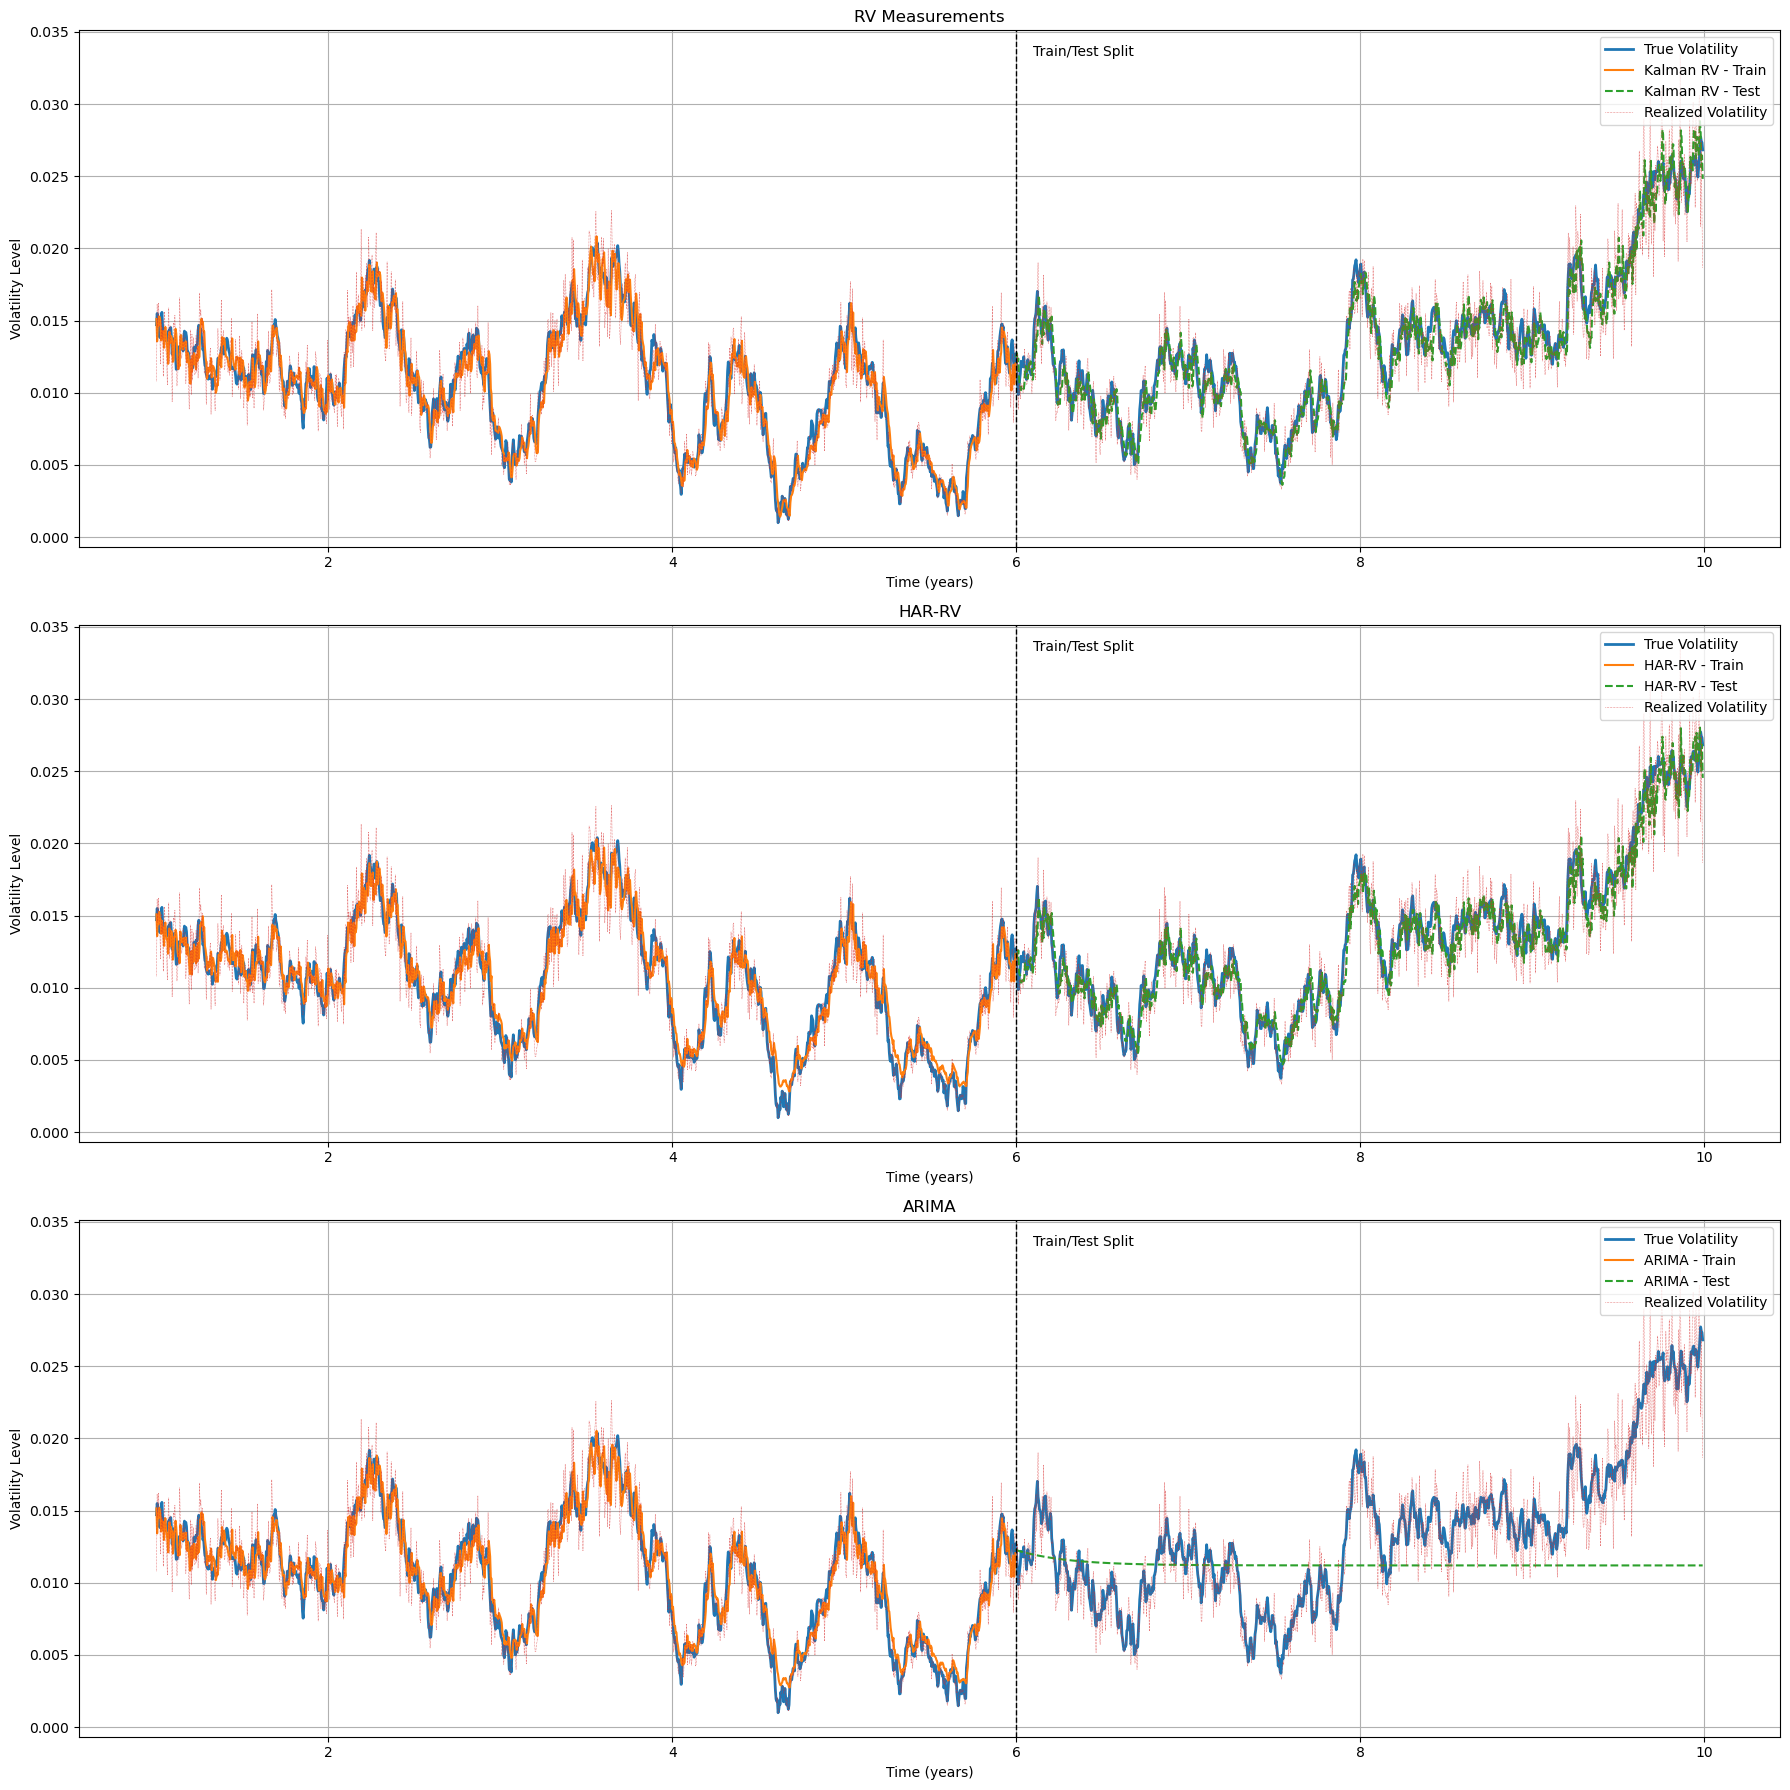

In [11]:
v_item = 'V_pred'

titles_all = ["RV Measurements", "HAR-RV", "ARIMA"]
labels_all = ["Kalman RV", "HAR-RV", "ARIMA"]
train_all = [train_result_rv[v_item], fit_HAR, fit_ARIMA]
test_all = [test_result_rv[v_item], pred_HAR, pred_ARIMA]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252
)

In [12]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'HAR-RV', 'ARIMA']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.001109, QLIKE: 0.018709
HAR-RV             RMSE: 0.001131, QLIKE: 0.018606
ARIMA              RMSE: 0.005531, QLIKE: 0.419959


In [13]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|██████████| 2/2 [00:00<00:00, 504.91model/s]


In [14]:
mcs_mse_results_90

,pvalues,status
models,,
3,0.0035,excluded
2,0.2594,included
1,1.0000,included


In [15]:
mcs_qlike_results_90

,pvalues,status
models,,
3,0.0007,excluded
1,0.9071,included
2,1.0000,included


In [16]:
mcs_mse_results_75

,pvalues,status
models,,
3,0.0026,excluded
2,0.2591,included
1,1.0000,included


In [17]:
mcs_qlike_results_75

,pvalues,status
models,,
3,0.0012,excluded
1,0.9084,included
2,1.0000,included
